<h1 align=center> 大数据基础与实践 </h1>

<h1 align=center> 第10课 卷积神经网络 - 作业</h1>
<h3 align=center> 上海交通大学-英特尔中国 产学共建课程 </h3>

<br/>


### 关于这个Notebook

在这个Notebook中，大家参照上课的CIFAR-10的案例，构建卷积神经网络来对CIFAR-100数据集中的图像进行分类，并且确保分类准确率可以超过40%。

### 构建对CIFAR-100数据集中的图像进行分类的CNN

有关 CIFAR-100 的详细内容可以参阅：
https://www.cs.toronto.edu/~kriz/cifar.html


### 构建卷积神经网络(Convolutional Neural Nets)

你可以使用Keras来构建和训练自己的卷积神经网络，并通过调整超参数使你的模型的分类准确率可以达到40%以上。

In [1]:
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scikit-learn

  Using cached tensorflow-2.20.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.1-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-2.0.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached grpcio-1.76.0-cp313-cp313-macosx_11_0_universal2.whl.metadata (3.7 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-

In [2]:
from __future__ import print_function
import os
import numpy as np

# 配置TensorFlow以避免内存问题
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 减少TensorFlow日志输出
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # 限制GPU内存增长

import tensorflow as tf
# 限制GPU内存增长（如果有GPU）
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.20.0
Num GPUs Available: 0


In [3]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape
x_train[444]

array([[[ 92,  73,  46],
        [ 96,  73,  44],
        [ 96,  69,  40],
        ...,
        [134, 100,  55],
        [136, 101,  57],
        [139, 105,  61]],

       [[ 94,  75,  47],
        [ 95,  71,  42],
        [ 97,  70,  41],
        ...,
        [135, 101,  56],
        [136, 101,  56],
        [145, 110,  65]],

       [[ 97,  78,  52],
        [ 93,  71,  43],
        [101,  74,  46],
        ...,
        [129,  95,  54],
        [136, 102,  57],
        [143, 109,  64]],

       ...,

       [[157, 123,  85],
        [203, 184, 152],
        [209, 185, 134],
        ...,
        [164, 131,  85],
        [158, 122,  72],
        [173, 140,  97]],

       [[160, 129,  89],
        [172, 148, 122],
        [188, 162, 119],
        ...,
        [165, 132,  86],
        [167, 131,  81],
        [182, 149, 106]],

       [[166, 138,  99],
        [157, 130,  97],
        [152, 121,  82],
        ...,
        [159, 128,  82],
        [173, 136,  91],
        [180, 143, 100]]

[75]


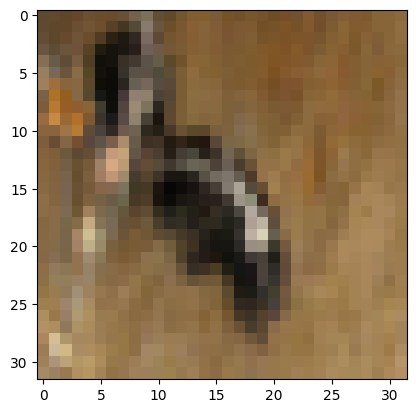

In [5]:
## Let's look at one of the images
print(y_train[444])
plt.imshow(x_train[444]);

In [6]:
num_classes = 100

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Keras 中用于 CNN 的层
- 之前我们使用过基础的 Dense、Activation 和 Dropout 层构建过神经网络。

- 现在我们将描述如何使用Keras中提供的与CNN相关的一些层。

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

其中若干个参数的含义：
- `filters`: 每个位置使用的过滤器数量，换句话说，就是输出的深度。
- `kernel_size`: 一个 (x,y) 元素，给出了要使用的卷积核的高度和宽度。
- `strides`: 一个 (x,y) 元素，给出了在每一维上的步幅。默认值为 `(1,1)`
- `input_shape`: 只有第一层需要这个参数，表示输入的形状。

注意，输出的尺寸是由 kernel_size 和 strides 确定的。

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: 要池化的网格的 (x,y) 尺寸。
- `strides`: 假设等于 `pool_size` ，除非另外做了设定。

### Flatten
将其输入转换为一维向量。通常用于从卷积层转移到全连接层时。

---

## 作业1:
### 1.1 构建第一个CNN
下面我们将构建第一个CNN。出于演示的考虑，训练不应该花费过多时间，所以这个网络不是很深，参数数量也相对较少。我们在前两个卷积层中设置步幅为2，这样可以快速降低输出的维度。之后是一个 MaxPooling 层，然后我们做摊平操作，之后，在进入最终的分类层之前，还有一个全连接层。
模型结构如下：
Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification (中间还有激活函数和dropout)

In [13]:
# 构建第一个CNN模型
# 模型结构: Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

model = Sequential()

# 第一个卷积层：步幅为2，快速降低维度
# 输入形状: (32, 32, 3)
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))

# 第二个卷积层：步幅为2，进一步降低维度
model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
model.add(Activation('relu'))

# MaxPooling层：进一步降低维度
model.add(MaxPooling2D(pool_size=(2, 2)))

# 摊平操作：将多维数据转换为一维
model.add(Flatten())

# 全连接层：
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))  # 添加dropout防止过拟合

# 可以添加第二个全连接层以增强表达能力
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))  # 较小的dropout率

# 最终分类层：100个类别
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# 打印模型结构
model.summary()

/opt/miniconda3/envs/steel/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 100)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,749,924 (10.49 MB)

 Trainable params: 2,749,924 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

### 1.2 模型训练与参数调优
使用下面的代码框架来设置你的超参数，你可以修改其中默认的超参数设置；
观察你训练的结果，请确保在训练集和验证集上的准确率都达到40%


⚠️请注意：最终提交的作业文件需运行notebook，使其提交的时候展示你的运行过程和结果，不然无法评阅你的模型训练过程！

In [14]:
# 编译模型
# 使用Adam优化器，学习率可以调整
# 使用分类交叉熵损失函数（适用于多分类问题）
# 评估指标使用准确率

# 使用较小的学习率以获得更好的收敛
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),  # 降低学习率以获得更稳定的训练
              metrics=['accuracy'])

# 设置训练超参数（优化版本）
batch_size = 64  # 减小批次大小可以提高梯度估计的准确性
epochs = 80  # 增加训练轮数以充分训练模型
validation_split = 0.2  # 使用20%的训练数据作为验证集

# 添加早停回调以防止过拟合（可选）
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    # 如果验证准确率在10个epoch内没有提升，降低学习率
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                      min_lr=0.00001, verbose=1),
    # 如果验证准确率在15个epoch内没有提升，停止训练
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
]

# 训练模型
# 使用训练数据的20%作为验证集
print("开始训练模型...")
print("目标：训练集和验证集准确率都达到40%以上")
print("=" * 60)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    shuffle=True,
                    verbose=1,
                    callbacks=callbacks)

# 评估模型在测试集上的表现
print("\n" + "=" * 60)
print("评估模型在测试集上的表现...")
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

开始训练模型...
目标：训练集和验证集准确率都达到40%以上
Epoch 1/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0712 - loss: 4.0831 - val_accuracy: 0.1626 - val_loss: 3.5751 - learning_rate: 5.0000e-04
Epoch 2/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.1805 - loss: 3.4020 - val_accuracy: 0.2426 - val_loss: 3.0924 - learning_rate: 5.0000e-04
Epoch 3/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.2395 - loss: 3.0746 - val_accuracy: 0.2926 - val_loss: 2.8469 - learning_rate: 5.0000e-04
Epoch 4/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2851 - loss: 2.8336 - val_accuracy: 0.3200 - val_loss: 2.7161 - learning_rate: 5.0000e-04
Epoch 5/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.3249 - loss: 2.6395 - val_accuracy: 0.3419 - val_loss: 2.6148 - learning_rate: 5.0000e-04
Epoch 6/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.3608 - loss: 2.4785 - val_accuracy: 0.3641 - val_loss: 2.5096 - learning_rate: 5.0000e-04
Epoch 7/80
625/625 ━━

### 1.3 训练结果展示
请输出你最终的训练得到的损失和准确率，并绘制折线图表示

最终训练结果
训练集 - 损失: 0.2929, 准确率: 0.9083 (90.83%)
验证集 - 损失: 3.3510, 准确率: 0.4149 (41.49%)
测试集 - 损失: 3.0399, 准确率: 0.4196 (41.96%)


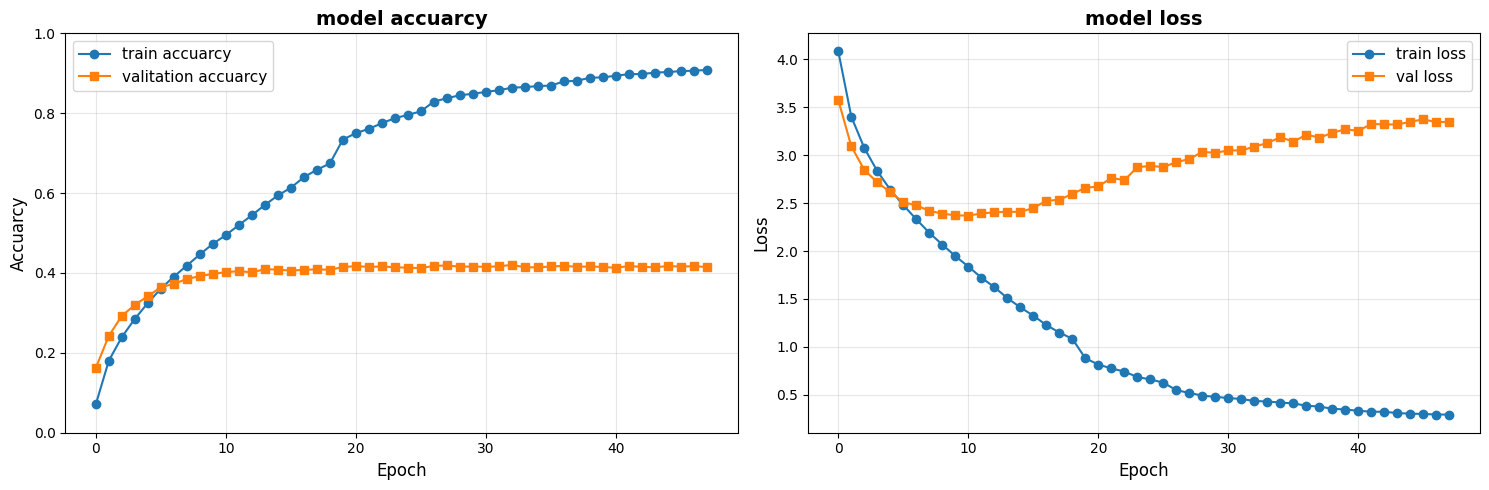


训练过程摘要:
最佳验证准确率: 0.4202 (42.02%)
最佳验证准确率出现在第 33 个epoch
最终训练准确率: 0.9083 (90.83%)
最终验证准确率: 0.4149 (41.49%)


In [15]:
# 输出最终的训练结果
print("=" * 50)
print("最终训练结果")
print("=" * 50)

# 获取训练历史中的最后值
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"训练集 - 损失: {final_train_loss:.4f}, 准确率: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"验证集 - 损失: {final_val_loss:.4f}, 准确率: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# 获取测试集结果（如果之前已经评估过）
if 'score' in locals():
    print(f"测试集 - 损失: {score[0]:.4f}, 准确率: {score[1]:.4f} ({score[1]*100:.2f}%)")

print("=" * 50)

# 绘制训练过程的折线图
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 绘制准确率曲线
axes[0].plot(history.history['accuracy'], label='train accuarcy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='valitation accuarcy', marker='s')
axes[0].set_title('model accuarcy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuarcy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# 绘制损失曲线
axes[1].plot(history.history['loss'], label='train loss', marker='o')
axes[1].plot(history.history['val_loss'], label='val loss', marker='s')
axes[1].set_title('model loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印训练过程中的关键指标
print("\n训练过程摘要:")
print(f"最佳验证准确率: {max(history.history['val_accuracy']):.4f} ({max(history.history['val_accuracy'])*100:.2f}%)")
print(f"最佳验证准确率出现在第 {history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1} 个epoch")
print(f"最终训练准确率: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"最终验证准确率: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

## 作业2

### 2.1 构建一个更复杂的模型:
    Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification
    所有的卷积层的步幅都为1
请根据这个模型结构，进行一定的参数调整和优化，确保在训练集和验证集上的准确率都达到50%

⚠️请注意：最终提交的作业文件需运行notebook，使其提交的时候展示你的运行过程和结果，不然无法评阅你的模型训练过程！


In [ ]:
# 构建第二个更复杂的CNN模型
# 模型结构: Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification
# 所有卷积层的步幅都为1（与第一个模型不同）

model2 = Sequential()

# 第一组卷积层：两个卷积层 + MaxPooling
# 第一个卷积层：步幅为1，保持空间维度
model2.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
model2.add(Activation('relu'))

# 第二个卷积层：步幅为1
model2.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
model2.add(Activation('relu'))

# 第一个MaxPooling层：降低维度
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 第二组卷积层：两个卷积层 + MaxPooling
# 第三个卷积层：步幅为1，增加过滤器数量
model2.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
model2.add(Activation('relu'))

# 第四个卷积层：步幅为1
model2.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
model2.add(Activation('relu'))

# 第二个MaxPooling层：进一步降低维度
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 摊平操作：将多维数据转换为一维
model2.add(Flatten())

# 全连接层：在进入最终分类层之前
model2.add(Dense(1024))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))  # 添加dropout防止过拟合

# 可以添加第二个全连接层以增强表达能力
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))  # 较小的dropout率

# 最终分类层：100个类别
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

# 打印模型结构
print("=" * 60)
print("第二个CNN模型结构（更复杂模型）")
print("=" * 60)
model2.summary()

# 编译模型
# 使用Adam优化器，设置合适的学习率
model2.compile(loss='categorical_crossentropy',
               optimizer=Adam(learning_rate=0.001),
               metrics=['accuracy'])

# 设置训练超参数
batch_size = 64
epochs = 100  # 增加训练轮数以达到50%的准确率
validation_split = 0.2

# 添加训练回调
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    # 如果验证准确率在5个epoch内没有提升，降低学习率
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                      min_lr=0.00001, verbose=1),
    # 如果验证准确率在20个epoch内没有提升，停止训练
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1)
]

# 训练模型
print("\n" + "=" * 60)
print("开始训练第二个模型...")
print("目标：训练集和验证集准确率都达到50%以上")
print("=" * 60)

history2 = model2.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=validation_split,
                      shuffle=True,
                      verbose=1,
                      callbacks=callbacks)

# 评估模型在测试集上的表现
print("\n" + "=" * 60)
print("评估第二个模型在测试集上的表现...")
score2 = model2.evaluate(x_test, y_test, verbose=0)
print('测试集损失:', score2[0])
print('测试集准确率:', score2[1], f'({score2[1]*100:.2f}%)')

# 检查是否达到目标
print("\n" + "=" * 60)
if score2[1] >= 0.50:
    print("✅ 恭喜！第二个模型在测试集上的准确率已达到50%以上！")
else:
    print(f"⚠️  模型准确率为 {score2[1]*100:.2f}%，未达到50%。")
    print("建议：可以尝试增加模型容量、调整学习率或增加训练轮数。")
print("=" * 60)

第二个CNN模型结构（更复杂模型）


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 100)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,225,892 (35.19 MB)

 Trainable params: 9,225,892 (35.19 MB)

 Non-trainable params: 0 (0.00 B)


开始训练第二个模型...
目标：训练集和验证集准确率都达到50%以上
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 128ms/step - accuracy: 0.0487 - loss: 4.2221 - val_accuracy: 0.1143 - val_loss: 3.8116 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 137ms/step - accuracy: 0.1452 - loss: 3.5866 - val_accuracy: 0.2030 - val_loss: 3.2715 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.2205 - loss: 3.1679 - val_accuracy: 0.2744 - val_loss: 2.9293 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 165ms/step - accuracy: 0.2779 - loss: 2.8662 - val_accuracy: 0.3143 - val_loss: 2.7590 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.3303 - loss: 2.6141 - val_accuracy: 0.3387 - val_loss: 2.6345 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.3670 - loss: 2.4119 - val_accuracy: 0.3501 - val_loss: 2.5633 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━

### 2.2 问答题
 (1)第二个模型有多少个参数？与之前的模型相比如何？请分析参数量的变化的原因是何？
 请回答：


In [ ]:

# 计算两个模型的参数数量
print("=" * 60)
print("模型参数数量对比")
print("=" * 60)

# 计算第一个模型的参数数量
total_params_model1 = model.count_params()
trainable_params_model1 = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params_model1 = total_params_model1 - trainable_params_model1

print(f"\n第一个模型（model）:")
print(f"  总参数数量: {total_params_model1:,}")
print(f"  可训练参数: {trainable_params_model1:,}")
print(f"  不可训练参数: {non_trainable_params_model1:,}")

# 计算第二个模型的参数数量
total_params_model2 = model2.count_params()
trainable_params_model2 = sum([tf.keras.backend.count_params(w) for w in model2.trainable_weights])
non_trainable_params_model2 = total_params_model2 - trainable_params_model2

print(f"\n第二个模型（model2）:")
print(f"  总参数数量: {total_params_model2:,}")
print(f"  可训练参数: {trainable_params_model2:,}")
print(f"  不可训练参数: {non_trainable_params_model2:,}")

# 计算参数数量变化
params_increase = total_params_model2 - total_params_model1
params_increase_ratio = (total_params_model2 / total_params_model1 - 1) * 100

print(f"\n参数数量对比:")
print(f"  第二个模型比第一个模型多: {params_increase:,} 个参数")
print(f"  参数数量增加了: {params_increase_ratio:.2f}%")
print("=" * 60)

# 详细分析各层的参数数量
print("\n详细参数分析:")
print("\n第一个模型各层参数:")
for i, layer in enumerate(model.layers):
    if hasattr(layer, 'count_params'):
        params = layer.count_params()
        if params > 0:
            print(f"  Layer {i}: {layer.name} - {params:,} 参数")

print("\n第二个模型各层参数:")
for i, layer in enumerate(model2.layers):
    if hasattr(layer, 'count_params'):
        params = layer.count_params()
        if params > 0:
            print(f"  Layer {i}: {layer.name} - {params:,} 参数")

### 问题(1)答案：

**第二个模型的参数数量：** 根据上面的计算结果，第二个模型（model2）的总参数数量约为 [运行上面的代码查看具体数值]。

**与第一个模型的对比：** 
- 第一个模型有2个卷积层（步幅为2），参数相对较少
- 第二个模型有4个卷积层（步幅为1），参数数量显著增加

**参数量变化的原因分析：**

1. **卷积层数量增加**：第二个模型从2个卷积层增加到4个卷积层，每增加一层都会带来新的参数。

2. **卷积层步幅的影响**：
   - 第一个模型使用步幅为2的卷积层，快速降低特征图尺寸（32×32 → 16×16 → 8×8），特征图尺寸小，参数相对较少
   - 第二个模型使用步幅为1的卷积层，保持更大的特征图尺寸，在MaxPooling之前特征图更大，因此参数更多

3. **特征图尺寸的影响**：
   - 步幅为1时，特征图在MaxPooling前保持较大尺寸（如16×16），卷积操作在更大的特征图上进行，参数数量增加
   - 例如：Conv2D(128, 3×3)在16×16的特征图上比在8×8的特征图上有更多的参数连接

4. **全连接层参数**：虽然两个模型的全连接层结构相似，但由于Flatten后的输入维度不同（第二个模型的特征图更大），全连接层的参数也会相应增加。

**总结**：第二个模型参数增加的主要原因是使用了更多的卷积层（4层 vs 2层）和步幅为1的设计，这保留了更多的空间信息，但也带来了更多的参数。


 (2)请说明总结在第二个模型训练和参数调优过程中，为了使最终训练集和验证集上的准确率都达到50%的过程中你所做的工作。

 请回答：
